Epoch: 001, Train: 0.7020, Test: 0.6480
Epoch: 002, Train: 0.7301, Test: 0.6700
Epoch: 003, Train: 0.7488, Test: 0.6860
Epoch: 004, Train: 0.7687, Test: 0.7040
Epoch: 005, Train: 0.7875, Test: 0.7420
Epoch: 006, Train: 0.8074, Test: 0.7520
Epoch: 007, Train: 0.8285, Test: 0.7800
Epoch: 008, Train: 0.8542, Test: 0.8100
Epoch: 009, Train: 0.8765, Test: 0.8340
Epoch: 010, Train: 0.8829, Test: 0.8500
Epoch: 011, Train: 0.8882, Test: 0.8500
Epoch: 012, Train: 0.8946, Test: 0.8560
Epoch: 013, Train: 0.9005, Test: 0.8560
Epoch: 014, Train: 0.9081, Test: 0.8620
Epoch: 015, Train: 0.9139, Test: 0.8660
Epoch: 016, Train: 0.9210, Test: 0.8660
Epoch: 017, Train: 0.9262, Test: 0.8720
Epoch: 018, Train: 0.9338, Test: 0.8780
Epoch: 019, Train: 0.9403, Test: 0.8800
Epoch: 020, Train: 0.9444, Test: 0.8820
Epoch: 021, Train: 0.9485, Test: 0.8880
Epoch: 022, Train: 0.9496, Test: 0.8840
Epoch: 023, Train: 0.9502, Test: 0.8820
Epoch: 024, Train: 0.9502, Test: 0.8880
Epoch: 025, Train: 0.9526, Test: 0.8900


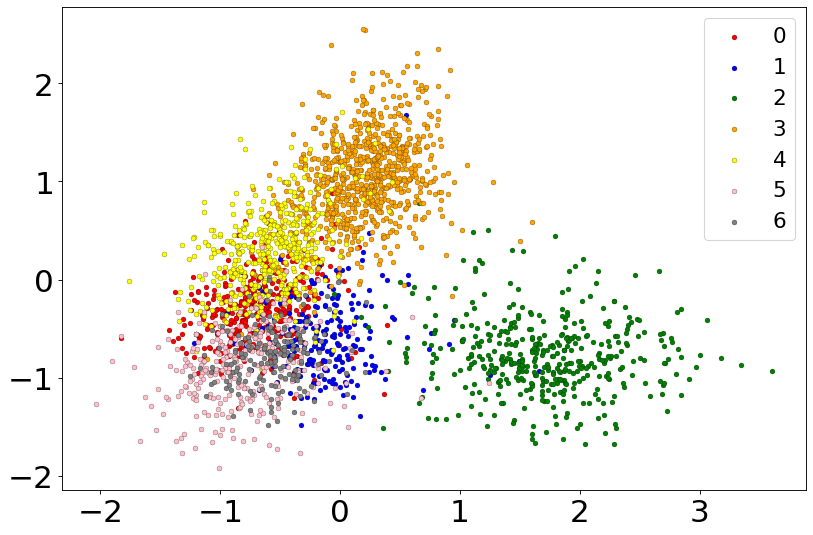

running tsne
tsne time 20.21841311454773
silhouette average 0.54022443 std 0.31032524
davies bouldin score 0.5705709479250747
calinski harabasz score 3127.3204010814525


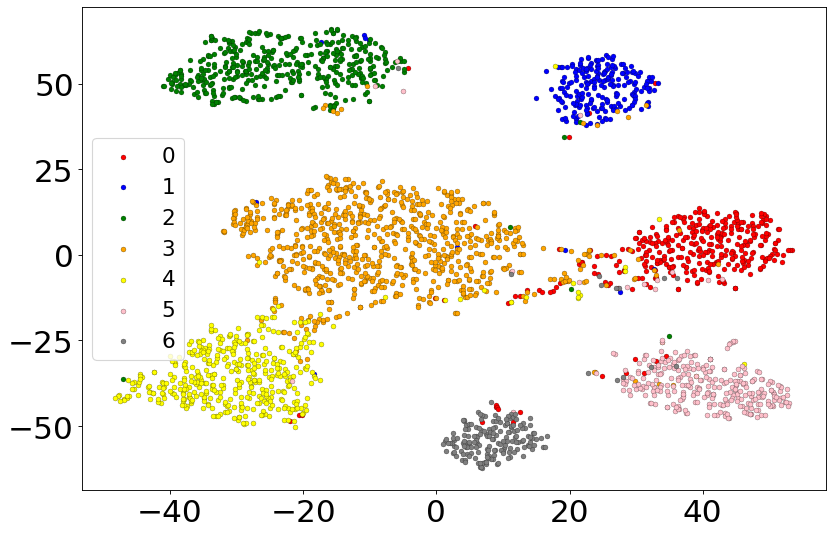

running umap
umap time 11.352934122085571
silhouette average 0.64054006 std 0.33382457
davies bouldin score 0.45002449856142585
calinski harabasz score 4626.843850851614


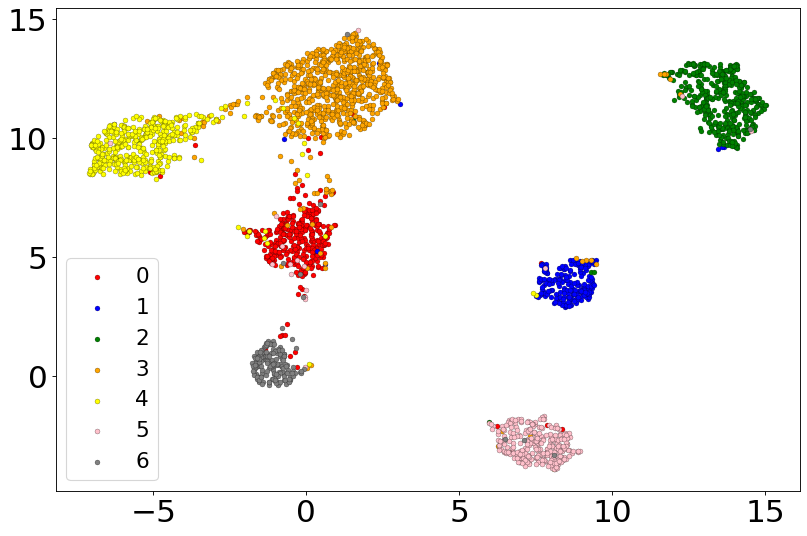

  0%|          | 0/2708 [00:00<?, ?it/s]

running ivis
Building KNN index
Extracting KNN neighbours


100%|██████████| 2708/2708 [00:00<00:00, 8871.27it/s] 


Training neural network
Epoch 1/1000
22/22 [==============================] - 1s 11ms/step - loss: 0.4698
Epoch 2/1000
22/22 [==============================] - 0s 11ms/step - loss: 0.2655
Epoch 3/1000
22/22 [==============================] - 0s 10ms/step - loss: 0.2451
Epoch 4/1000
22/22 [==============================] - 0s 12ms/step - loss: 0.2055
Epoch 5/1000
22/22 [==============================] - 0s 12ms/step - loss: 0.2127
Epoch 6/1000
22/22 [==============================] - 0s 10ms/step - loss: 0.2232
Epoch 7/1000
22/22 [==============================] - 0s 11ms/step - loss: 0.1963
Epoch 8/1000
22/22 [==============================] - 0s 11ms/step - loss: 0.1862
Epoch 9/1000
22/22 [==============================] - 0s 12ms/step - loss: 0.1836
Epoch 10/1000
22/22 [==============================] - 0s 11ms/step - loss: 0.1842
Epoch 11/1000
22/22 [==============================] - 0s 12ms/step - loss: 0.1783
Epoch 12/1000
22/22 [==============================] - 0s 11ms/step - lo

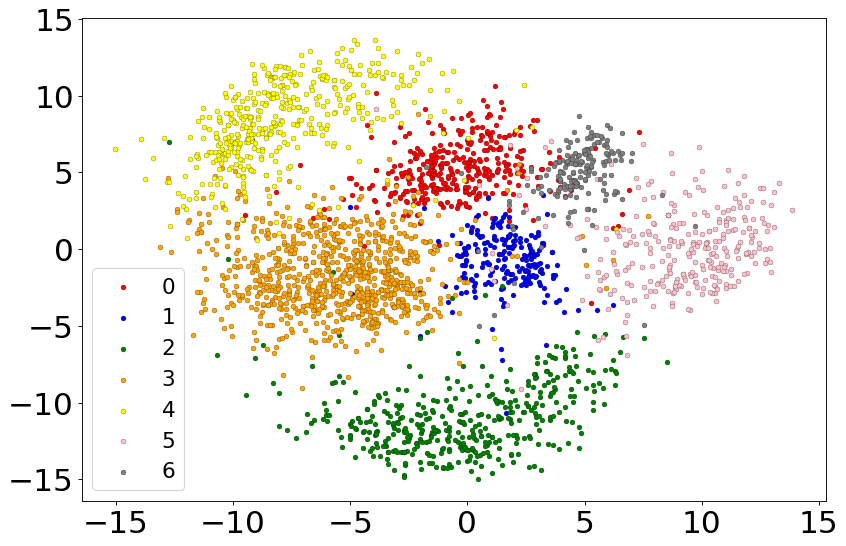

In [5]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install umap-learn
!pip install ivis[cpu]

import torch
import os.path as osp
import torch.nn.functional as F
from torch_geometric.datasets import MNISTSuperpixels, Planetoid
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.nn import SplineConv, voxel_grid, max_pool, max_pool_x
from torch_spline_conv import spline_conv
import torch_cluster
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.io import savemat
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
from ivis import Ivis
import time
import numpy as np
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, TUDataset, Entities
import torch_geometric.transforms as T
from torch_geometric.nn import SplineConv
import sys
sys.path.append('/content/drive/MyDrive/Thesis')
from visualize_embeddings import *

dataset = 'Cora'
#dataset = 'ENZYMES'
transform = T.Compose([
    T.AddTrainValTestMask('train_rest', num_val=500, num_test=500),
    T.TargetIndegree(),])

path = "/content/drive/MyDrive/Thesis/SplineCNN/"
dataset = Planetoid(path, dataset, transform=transform)
#dataset = TUDataset(path,dataset,transform=transform)
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SplineConv(dataset.num_features, 16, dim=1, kernel_size=2)
        self.conv2 = SplineConv(16, dataset.num_classes, dim=1, kernel_size=2)
        #self.conv3 = SplineConv(16, 2, dim=1, kernel_size=2)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, training=self.training)
        #t = F.elu(self.conv3(x, edge_index, edge_attr))
        # t = F.dropout(t, training=self.training)
        hidden = x
        x = self.conv2(x, edge_index, edge_attr)
        return hidden, F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


def train():
    model.train()
    optimizer.zero_grad()
    hidden, output = model()
    F.nll_loss(output[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()
    return hidden[data.train_mask], data.y[data.train_mask]


def test():
    model.eval()
    log_probs, accs = model(), []
    for _, mask in data('train_mask', 'test_mask'):
        hidden = log_probs[0]
        pred = log_probs[1][mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs, hidden, data.y


for epoch in range(1, 201):
    hidden_train, labels_train = train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'
    acc, hidden_all, labels_all = test()
    #print(log.format(epoch, test_acc))
    print('Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'.format(epoch, *acc))
    if epoch ==200:
                hidden_train = hidden_train.cpu().detach().numpy()
                hidden_test = hidden_all[data.test_mask].cpu().detach().numpy()
                hidden_all = hidden_all.cpu().detach().numpy()
                labels_train = labels_train.cpu().detach().numpy()
                labels_test = labels_all[data.test_mask].cpu().detach().numpy()
                labels_all = labels_all.cpu().detach().numpy()
                savemat('splinecora.mat', {'splinecora_embeddings_all': hidden_all,'splinecora_node_labels_all': labels_all, 'splinecora_embeddings_train': hidden_train,'splinecora_node_labels_train': labels_train, 'splinecorA_embeddings_test': hidden_test,'splinecora_node_labels_test': labels_test})
                num_classes = len(set(labels_train))

                label_array = np.zeros(len(labels_all))-1
                train_mask = data.train_mask.cpu().numpy().astype(np.bool)
                label_array[train_mask] = labels_all[train_mask]

                methods = ['pca','tsne','umap','ivis']
                run_visualizations(methods,hidden_embeddings=hidden_all,
                                   labels=labels_all,perplexity=30,neighbors=10,min_dist=0.2,supervised=False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')